In [19]:
import boto3
import io
import pickle

s3 = boto3.resource(
    's3',
    aws_access_key_id='<aws_access_key_id>',
    aws_secret_access_key='<aws_secret_access_key>'
)

bucket = s3.Bucket('kkik-tracking')

def put_obj(bucket, key, obj):
    pkl = io.BytesIO()
    pickle.dump(obj, pkl)
    pkl.seek(0)
    bucket.upload_fileobj(pkl, key)
    
def get_obj(bucket, key):
    # This function is unsafe when 
    # loading data from unknown sources.

    pkl = io.BytesIO()
    bucket.download_fileobj(key, pkl)
    pkl.seek(0)

    return pickle.loads(pkl.read())

In [20]:
import requests
from bs4 import BeautifulSoup

def kkik_session():
    url = "https://www.kollegierneskontor.dk/default.aspx"

    params = {
        'func': 'kkikportal.login',
        'lang': 'GB'
    }
    
    headers = {
        'connection': "keep-alive",
        'pragma': "no-cache",
        'cache-control': "no-cache",
        'upgrade-insecure-requests': "1",
        'user-agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36 OPR/54.0.2952.71",
        'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        'accept-encoding': "gzip, deflate, br",
        'accept-language': "en-US,en;q=0.9"
    }

    response = requests.request("GET", url, params=params, headers=headers)
    bs = BeautifulSoup(response.text)
    asp_junk = {tag.get('id'): tag.get('value') for tag in bs.select('.aspNetHidden input')}

    return response.cookies['ASP.NET_SessionId'], asp_junk

def kkik_login(session, payload, mail, pwd):
    cookies = {
        'ASP.NET_SessionId': session,
    }

    headers = {
        'connection': "keep-alive",
        'pragma': "no-cache",
        'cache-control': "no-cache",
        'upgrade-insecure-requests': "1",
        'user-agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36 OPR/54.0.2952.71",
        'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        'accept-encoding': "gzip, deflate, br",
        'accept-language': "en-US,en;q=0.9",
        'content-type': 'application/x-www-form-urlencoded',
    }

    params = (
        ('lang', 'GB'),
        ('func', 'kkikportal.login'),
    )

    data = {
        'Page$ctl08$Main$ctl04$form$loginUserName': mail,
        'Page$ctl08$Main$ctl04$form$loginPassword': pwd,
        'Page$ctl08$Main$ctl04$form$loginButton': 'Log+ind'
    }
    data.update(payload)

    return requests.post('https://www.kollegierneskontor.dk/default.aspx', headers=headers, params=params, cookies=cookies, data=data)


    
def kkik_housingrequests(session):
    url = "https://www.kollegierneskontor.dk/default.aspx"

    cookies = {
        'ASP.NET_SessionId': session,
    }

    params = {
        'func': 'kkikportal.housingrequests',
        'lang': 'GB'
    }

    headers = {
        'connection': "keep-alive",
        'pragma': "no-cache",
        'cache-control': "no-cache",
        'upgrade-insecure-requests': "1",
        'user-agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36 OPR/54.0.2952.71",
        'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        'accept-encoding': "gzip, deflate, br",
        'accept-language': "en-US,en;q=0.9"
    }

    return requests.request("GET", url, params=params, headers=headers, cookies=cookies)

In [21]:
from datetime import datetime
from botocore.exceptions import ClientError
from pprint import pprint

sesssion, asp_junk = kkik_session()
kkik_login(sesssion, asp_junk, '<user_mail>', '<user_pass>')
housings = kkik_housingrequests(sesssion)

bs = BeautifulSoup(housings.text)

try:
    data = get_obj(bucket, 'test')
except ClientError:
    data = {}

for row in bs.select('div.row.header')[1:]:
    cols = [col.getText().replace('\n', '').strip() for col in row.select('div')[3::2]]
    name = tuple(cols[:-1])
    pos = int(cols[-1])
    data[name] = data.get(name, []) + [(datetime.now(), pos)]


put_obj(bucket, 'test', data)

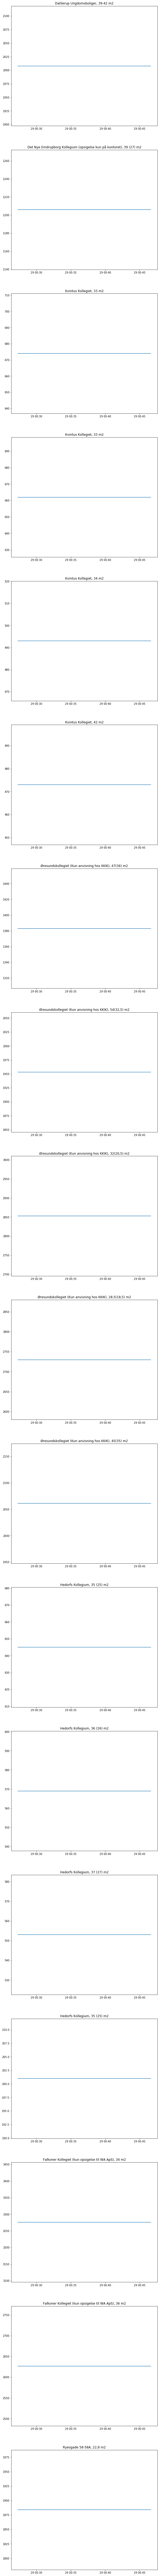

In [22]:
import matplotlib.pyplot as plt
plot_count = len(data)

f = plt.figure(figsize=(10,10*plot_count))
for i, (apt, records) in enumerate(data.items()):    
    ax = f.add_subplot(plot_count,1,i+1)
    ax.set_title(f'{apt[0]}, {apt[2]}')
    ax.plot(*zip(*records))

graph = io.BytesIO()
f.savefig(graph, format='png')
graph.seek(0)
bucket.upload_fileobj(graph, 'kkik-tracking.png')